In [1]:
import sys
import os
src_path = os.path.abspath(os.path.join('..', 'src'))
if src_path not in sys.path:
    sys.path.append(src_path)

In [2]:
from connector import spark_connector

In [3]:
import pandas as pd
import numpy as np
from pyspark.sql import Window
import pyspark.sql.functions as F
import pyspark.sql.types as T

In [4]:
spark_connector?

Init signature:
spark_connector(
    exec_inst: int = 100,
    exec_cores: int = 5,
    aloc_max: int = 500,
    memory_exec: int = 25,
    name: object = 'utopialvo',
    rootdir: object = 'remote_dir_in_hdft',
    enable_graphframes: bool = False,
    enable_clickhouse: bool = False,
    enable_postgres: bool = False,
    dynamic_allocation: bool = False,
    intensive_mode: bool = False,
    marshal_mode: bool = True,
    yarn: bool = True,
) -> None
Docstring:     
Класс стандартного подключения к Spark

exec_inst - количество контейнеров
exec_cores - количество ядер в контейнере
aloc_max - максимальное количество ядер для dynamic_allocation (если он вкл)
memory_exec - количество памяти в контейнере
name - название подключения для упрощения логгирования подключений в кластере
rootdir - корневая папка в HDFS 
enable_graphframes - включить работу с graphframes
enable_clickhouse - включить работу с clickhouse
enable_postgres - включить работу с postgres
dynamic_allocation - включить д

In [5]:
con = spark_connector(exec_inst=100, exec_cores=5, memory_exec=25, enable_graphframes=True, marshal_mode=False, yarn = False)

In [6]:
con.spark

In [ ]:
#con.stop_spark()

time: 2025-02-25 21:17:16.678262


In [9]:
from sklearn.datasets import make_blobs

In [10]:
X, y, c = make_blobs(n_samples=5000, n_features=2, centers=14, cluster_std=1.0, center_box=(-30.0, 30.0), shuffle=True, random_state=0, return_centers=True)

In [11]:
data = pd.DataFrame(X, columns=[f'x{i+1}' for i in range(X.shape[1])])
data['y'] = y
data = data.merge(pd.DataFrame(c, columns=[f'centroids_{i+1}' for i in range(X.shape[1])]).reset_index(), left_on='y', right_on='index', how='left').drop('index', axis=1)

In [12]:
data

,x1,x2,y,centroids_1,centroids_2
0,16.431196,22.046133,9,16.689405,22.200729
1,-23.059022,25.344576,13,-21.398803,26.680135
2,27.034981,-7.163631,4,27.819766,-6.993509
3,-21.078975,26.437051,13,-21.398803,26.680135
4,-3.711706,8.937828,2,-4.580712,8.753647
...,...,...,...,...,...
4995,-2.566938,21.201213,3,-3.744767,23.506380
4996,-20.665745,26.298933,13,-21.398803,26.680135
4997,5.018192,2.334877,1,6.165803,2.692991
4998,-2.708401,16.633889,11,-2.311238,16.831751


In [13]:
import seaborn as sns

<Axes: xlabel='x1', ylabel='x2'>

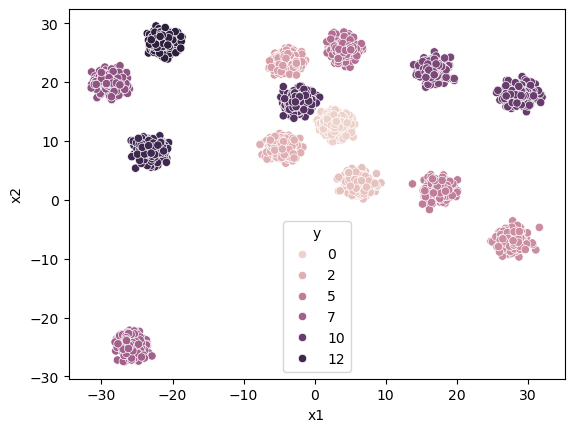

In [14]:
sns.scatterplot(x=data.x1, y=data.x2, hue=data.y)

In [18]:
train_df = data.drop(['centroids_1','centroids_2'], axis=1).reset_index(names='id')

In [19]:
from norm import NormalizerPandas

In [20]:
normalizer = NormalizerPandas(
    methods={
        'x1': 'range',
        'x2': 'range'
    },
    columns=train_df.drop(['id','y'], axis=1).columns
)
normalizer.fit(train_df)

In [21]:
print(normalizer.stats)

{'x1': {'method': 'range', 'min': -31.446918071295425, 'max': 32.009794855681804, 'mean': -0.41954920840941934}, 'x2': {'method': 'range', 'min': -27.531169542145086, 'max': 29.54533856348939, 'mean': 11.083316527343868}}


In [22]:
df_normalized = normalizer.transform(train_df)

In [24]:
feature = con.spark.createDataFrame(df_normalized)

In [25]:
communities_data = feature.select('id','y')
feature = feature.drop('y')

In [48]:
from stack import SparkSimilarMatrix

In [49]:
SparkSimilarMatrix?

Init signature:
SparkSimilarMatrix(
    spark: pyspark.sql.session.SparkSession,
    train_df: pyspark.sql.dataframe.DataFrame,
) -> None
Docstring:     
Вычисление матрицы схожести в распределенном режиме.

Пример использования:
>>> sim = SparkSimilarMatrix(spark, train_df)
>>> sim.prep()
>>> sim.create_sim_matrix(metric='cosine')
>>> sim.create_degree_matrix(treshold=0.75)
File:           ~/work/Spark_conn/src/stack.py
Type:           type
Subclasses:     

In [64]:
sim = SparkSimilarMatrix(con.spark, feature)

In [65]:
sim.prep()

In [66]:
sim.create_sim_matrix()

In [67]:
#sim.create_sim_matrix(metric='cosine')
#sim.sim_matrix = sim.sim_matrix.withColumn('distance', (1 - F.col('distance')))

In [68]:
sim.sim_matrix.select(F.max('distance'), F.min('distance')).collect()

[Row(max(distance)=1.238398129453286, min(distance)=1.549435171932168e-05)]

In [55]:
#sim.sim_matrix = sim.sim_matrix.withColumn('distance', 1 - (F.col('distance') / 1.238398129453286))

In [92]:
communities_data#.select(F.col('id').alias('item'),'y')

DataFrame[id: bigint, y: bigint]

In [95]:
sim.sim_matrix

DataFrame[id_A: bigint, id_B: bigint, distance: double]

In [103]:
from pyspark.sql import functions as F
from pyspark.sql import DataFrame

def calculate_modularity(
    edges_df: DataFrame,
    communities_df: DataFrame,
    item_col: str = 'item',
    itemA_col: str = 'itemA',
    itemB_col: str = 'itemB',
    distance_col: str = 'distance',
    community_col: str = 'community',
    distance_type: str = 'euclidean',
    weight_transform: callable = None,
    check_nodes: bool = True
) -> float:
    """
    Вычисляет модулярность графа с поддержкой разных типов расстояний
    
    Параметры:
    edges_df: DataFrame с ребрами (itemA, itemB, distance)
    communities_df: DataFrame с принадлежностью узлов к сообществам
    item_col: Название колонки с узлами в communities_df
    distance_type: 'euclidean' или 'cosine'
    weight_transform: пользовательская функция преобразования расстояния в вес
    check_nodes: Проверять наличие всех узлов в communities_df
    
    Возвращает:
    Значение модулярности в диапазоне [-1, 1]
    """
    
    # Проверка наличия всех узлов в communities_df
    if check_nodes:
        nodes = (edges_df.select(itemA_col)
                 .union(edges_df.select(itemB_col))
                 .distinct()
                 .withColumnRenamed(itemA_col, 'node'))
        
        missing = nodes.join(
            communities_df.select(F.col(item_col).alias('node')),
            'node',
            'left_anti'
        )
        
        if missing.count() > 0:
            missing_list = missing.limit(10).toPandas()['node'].tolist()
            raise ValueError(f"Nodes missing in communities_df: {missing_list}")

    # Преобразование расстояния в вес
    if weight_transform is None:
        if distance_type == 'euclidean':
            df_weights = edges_df.withColumn("weight", 1 / (1 + F.greatest(F.col(distance_col), F.lit(0))))
            #weight_transform = lambda d: 1 / (1 + F.greatest(d, 0))
        elif distance_type == 'cosine':
            df_weights = edges_df.withColumn("weight", (1 - F.greatest(F.least(F.col(distance_col), F.lit(1)), -1)) / 2)
            #weight_transform = lambda d: (1 - F.greatest(F.least(d, 1), -1)) / 2
        else:
            raise ValueError(f"Unsupported distance type: {distance_type}")

    #df_weights = edges_df.withColumn("weight", weight_transform(F.col(distance_col)))

    # Проверка валидности весов
    min_weight = df_weights.agg(F.min("weight")).first()[0]
    if min_weight < 0:
        raise ValueError("Weights must be non-negative")

    # Создание симметричной матрицы и удаление дубликатов
    reverse_df = (df_weights
                  .select(
                      F.col(itemB_col).alias(itemA_col),
                      F.col(itemA_col).alias(itemB_col),
                      "weight"
                  ))
    
    sym_df = (df_weights.drop(distance_col).unionByName(reverse_df)
              .dropDuplicates([itemA_col, itemB_col])
              .cache())

    # Расчет общего веса графа
    total_weight = sym_df.agg(F.sum("weight")).first()[0]
    if total_weight == 0:
        return 0.0  # Граф без связей
    m = total_weight / 2.0

    # Подготовка данных о сообществах
    communities = communities_df.select(
        F.col(item_col).alias('node'),
        F.col(community_col)
    ).cache()

    # Присоединение информации о сообществах
    joined = (sym_df
              .join(
                  communities.alias('a'),
                  F.col(itemA_col) == F.col('a.node'),
                  'inner'
              )
              .join(
                  communities.alias('b'),
                  F.col(itemB_col) == F.col('b.node'),
                  'inner'
              )
              .select(
                  F.col(itemA_col),
                  F.col(itemB_col),
                  'weight',
                  F.col('a.' + community_col).alias('comA'),
                  F.col('b.' + community_col).alias('comB')
              ))

    # Расчет компонентов модулярности
    joined = joined.withColumn(
        'delta', 
        F.when(F.col('comA') == F.col('comB'), 1).otherwise(0)
    )

    # Сумма A_ij * delta
    sum_Aij_delta = joined.agg(F.sum(F.col('weight') * F.col('delta'))).first()[0] or 0.0

    # Расчет степеней вершин
    degrees = (sym_df
               .groupBy(itemA_col)
               .agg(F.sum('weight').alias('degree'))
               .cache())

    # Расчет суммы (k_i k_j / 2m) * delta
    joined_degrees = (joined
                      .join(
                          degrees.alias('ki'),
                          itemA_col
                      )
                      .join(
                          degrees.alias('kj'),
                          itemB_col
                      )
                      .select(
                          'delta',
                          F.col('ki.degree').alias('k_i'),
                          F.col('kj.degree').alias('k_j')
                      ))

    sum_kikj = joined_degrees.agg(
        F.sum(F.col('k_i') * F.col('k_j') * F.col('delta') / (2 * m))
    ).first()[0] or 0.0

    # Расчет модулярности
    modularity = (sum_Aij_delta - sum_kikj) / total_weight

    # Очистка кэша
    sym_df.unpersist()
    degrees.unpersist()
    communities.unpersist()

    return float(modularity)

In [104]:
calculate_modularity?

Signature:
calculate_modularity(
    edges_df: pyspark.sql.dataframe.DataFrame,
    communities_df: pyspark.sql.dataframe.DataFrame,
    item_col: str = 'item',
    itemA_col: str = 'itemA',
    itemB_col: str = 'itemB',
    distance_col: str = 'distance',
    community_col: str = 'community',
    distance_type: str = 'euclidean',
    weight_transform: <built-in function callable> = None,
    check_nodes: bool = True,
) -> float
Docstring:
Вычисляет модулярность графа с поддержкой разных типов расстояний

Параметры:
edges_df: DataFrame с ребрами (itemA, itemB, distance)
communities_df: DataFrame с принадлежностью узлов к сообществам
item_col: Название колонки с узлами в communities_df
distance_type: 'euclidean' или 'cosine'
weight_transform: пользовательская функция преобразования расстояния в вес
check_nodes: Проверять наличие всех узлов в communities_df

Возвращает:
Значение модулярности в диапазоне [-1, 1]
File:      /tmp/ipykernel_42383/3661300588.py
Type:      function

In [105]:
mod = calculate_modularity(
    edges_df = sim.sim_matrix,
    item_col='id',
    itemA_col = 'id_A', 
    itemB_col = 'id_B',
    communities_df = communities_data,
    distance_type='euclidean', 
    community_col='y')


KeyboardInterrupt



In [106]:
mod

NameError: name 'mod' is not defined

In [ ]:
mod = calculate_modularity(
    edges_df = sim.sim_matrix,
    item_col='id',
    itemA_col = 'id_A', 
    itemB_col = 'id_B',
    communities_df = communities_data,
    distance_type='cosine', 
    community_col='y')

In [ ]:
mod

In [57]:
# Шаг 1: Связываем матрицу с информацией о сообществах
joined_df = sim.sim_matrix.join(
    communities_data, 
    sim.sim_matrix.id_A == communities_data.id, 
    'left'
).select(
    sim.sim_matrix['*'], 
    communities_data['y'].alias('communityA')
).join(
    communities_data, 
    sim.sim_matrix.id_B == communities_data.id, 
    'left'
).select(
    'id_A', 
    'id_B', 
    'distance', 
    'communityA', 
    F.col('y').alias('communityB')
)

In [58]:
# Шаг 2: Сумма весов внутри сообществ
intra_sum = joined_df.filter(
    F.col('communityA') == F.col('communityB')
).agg(
    F.sum('distance').alias('intra_sum')
).collect()[0]['intra_sum'] or 0.0

In [59]:
# Шаг 3: Общая сумма всех весов (m)
m = sim.sim_matrix.agg(F.sum('distance')).collect()[0][0] / 2 or 0.0

In [60]:
# Шаг 4: Рассчитываем степени узлов
degrees = sim.sim_matrix.select(
    F.col('id_A').alias('item'),
    F.col('distance')
).union(
    sim.sim_matrix.select(
        F.col('id_B').alias('item'),
        F.col('distance')
    )
).groupBy(F.col('item').alias('id')).agg(
    F.sum('distance').alias('degree')
)

In [61]:
# Шаг 5: Сумма квадратов степеней сообществ
#community_degrees = communities_data.join(degrees, 'id', 'left')
sum_sq_degrees = communities_data.join(degrees, 'id', 'left').groupBy('y').agg(
    F.sum('degree').alias('total_degree')
).agg(
    F.sum(F.col('total_degree') ** 2)
).collect()[0][0] or 0.0

In [62]:
# Шаг 6: Вычисляем модулярность
if m != 0:
    modularity = (intra_sum - (sum_sq_degrees / (2 * m))) / (2 * m)
else:
    modularity = 0.0

print(f"Modularity score: {modularity:.4f}")

Modularity score: -0.0177


In [ ]:
# # Пример данных: матрица схожести (нижний треугольник)
# similarities_data = [
#     ('A', 'B', 1.0),
#     ('A', 'C', 0.5),
#     ('B', 'C', 0.7),
#     ('B', 'D', 0.3),
#     ('C', 'D', 0.6)
# ]
# similarities = spark.createDataFrame(
#     similarities_data, 
#     ['itemA', 'itemB', 'distance']
# )

# # Пример данных с сообществами
# communities_data = [
#     ('A', 0),
#     ('B', 0),
#     ('C', 1),
#     ('D', 1)
# ]
# communities = spark.createDataFrame(
#     communities_data, 
#     ['item', 'community']
# )

# Шаг 1: Связываем матрицу с информацией о сообществах
joined_df = similarities.join(
    communities, 
    similarities.itemA == communities.item, 
    'left'
).select(
    similarities['*'], 
    communities['community'].alias('communityA')
).join(
    communities, 
    similarities.itemB == communities.item, 
    'left'
).select(
    'itemA', 
    'itemB', 
    'distance', 
    'communityA', 
    F.col('community').alias('communityB')
)

# Шаг 2: Сумма весов внутри сообществ
intra_sum = joined_df.filter(
    F.col('communityA') == F.col('communityB')
).agg(
    F.sum('distance').alias('intra_sum')
).collect()[0]['intra_sum'] or 0.0

# Шаг 3: Общая сумма всех весов (m)
m = similarities.agg(F.sum('distance')).collect()[0][0] or 0.0

# Шаг 4: Рассчитываем степени узлов
degrees = similarities.select(
    F.col('itemA').alias('item'),
    F.col('distance')
).union(
    similarities.select(
        F.col('itemB').alias('item'),
        F.col('distance')
    )
).groupBy('item').agg(
    F.sum('distance').alias('degree')
)

# Шаг 5: Сумма квадратов степеней сообществ
community_degrees = communities.join(degrees, 'item', 'left')
sum_sq_degrees = community_degrees.groupBy('community').agg(
    F.sum('degree').alias('total_degree')
).agg(
    F.sum(F.col('total_degree') ** 2)
).collect()[0][0] or 0.0

# Шаг 6: Вычисляем модулярность
if m != 0:
    modularity = (intra_sum - (sum_sq_degrees / (2 * m))) / (2 * m)
else:
    modularity = 0.0

print(f"Modularity score: {modularity:.4f}")

# Результат: 
# Для приведенных данных Modularity score: 0.0303